In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from adtk.data import validate_series
from adtk.detector import ThresholdAD
from adtk.visualization import plot
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

Загрузка даних

In [2]:
dataset = pd.read_excel('test.xlsx', index_col='Date')
dataset.head()

,Quantity
Date,
2016-01-01,8
2016-02-01,165
2016-03-01,296
2016-04-01,1065
2016-05-01,1185


In [3]:
dataset.tail()

,Quantity
Date,
2019-08-01,372
2019-09-01,122
2019-10-01,18
2019-11-01,10
2019-12-01,12


In [4]:
dataset = validate_series(dataset)
print(dataset)

            Quantity
Date                
2016-01-01         8
2016-02-01       165
2016-03-01       296
2016-04-01      1065
2016-05-01      1185
2016-06-01      1083
2016-07-01       598
2016-08-01       152
2016-09-01        87
2016-10-01        12
2016-11-01         1
2016-12-01        10
2017-01-01        28
2017-02-01        41
2017-03-01       273
2017-04-01      1041
2017-05-01      1224
2017-06-01      1219
2017-07-01       752
2017-08-01       255
2017-09-01        88
2017-10-01        20
2017-11-01        18
2017-12-01         9
2018-01-01        39
2018-02-01       105
2018-03-01       285
2018-04-01      1643
2018-05-01      2020
2018-06-01      1211
2018-07-01       911
2018-08-01       391
2018-09-01       113
2018-10-01        22
2018-11-01         4
2018-12-01         8
2019-01-01        15
2019-02-01       163
2019-03-01       288
2019-04-01      1102
2019-05-01      1539
2019-06-01      1225
2019-07-01       841
2019-08-01       372
2019-09-01       122
2019-10-01   

In [5]:
dataset.head()

,Quantity
Date,
2016-01-01,8
2016-02-01,165
2016-03-01,296
2016-04-01,1065
2016-05-01,1185


In [6]:
dataset.tail()

,Quantity
Date,
2019-08-01,372
2019-09-01,122
2019-10-01,18
2019-11-01,10
2019-12-01,12


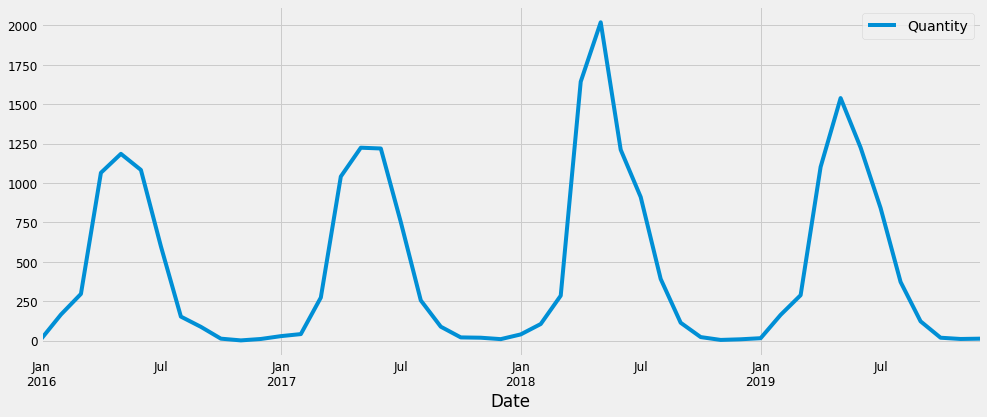

In [7]:
dataset.plot(figsize=(15,6))
plt.show()

Виявлення аномалій

In [8]:
dataset.describe()

,Quantity
count,48.000000
mean,460.187500
std,550.130648
min,1.000000
25%,19.500000
50%,164.000000
75%,943.500000
max,2020.000000


[<AxesSubplot:>]

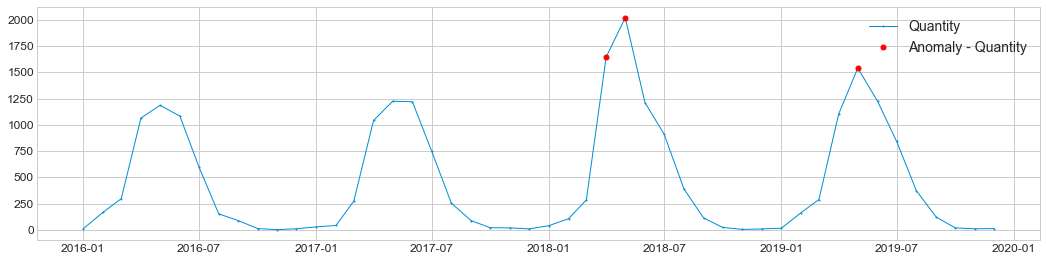

In [9]:
threshold_ad = ThresholdAD(high=1300)
anomalies = threshold_ad.detect(dataset)
plot(dataset, anomaly=anomalies, ts_linewidth=1, anomaly_markersize=5, anomaly_color='red', anomaly_tag = 'marker')

In [10]:
anomalies[anomalies.Quantity]

,Quantity
Date,
2018-04-01,True
2018-05-01,True
2019-05-01,True


[<AxesSubplot:>]

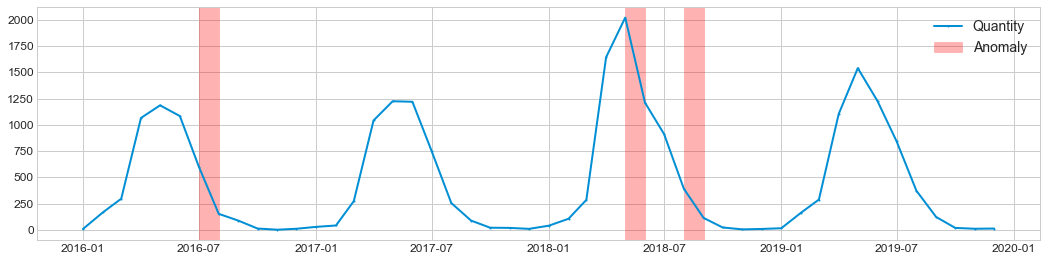

In [11]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(dataset)
plot(dataset, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

In [12]:
anomalies[anomalies]

Date
2016-07-01    True
2018-05-01    True
2018-08-01    True
dtype: bool

In [13]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)            
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()

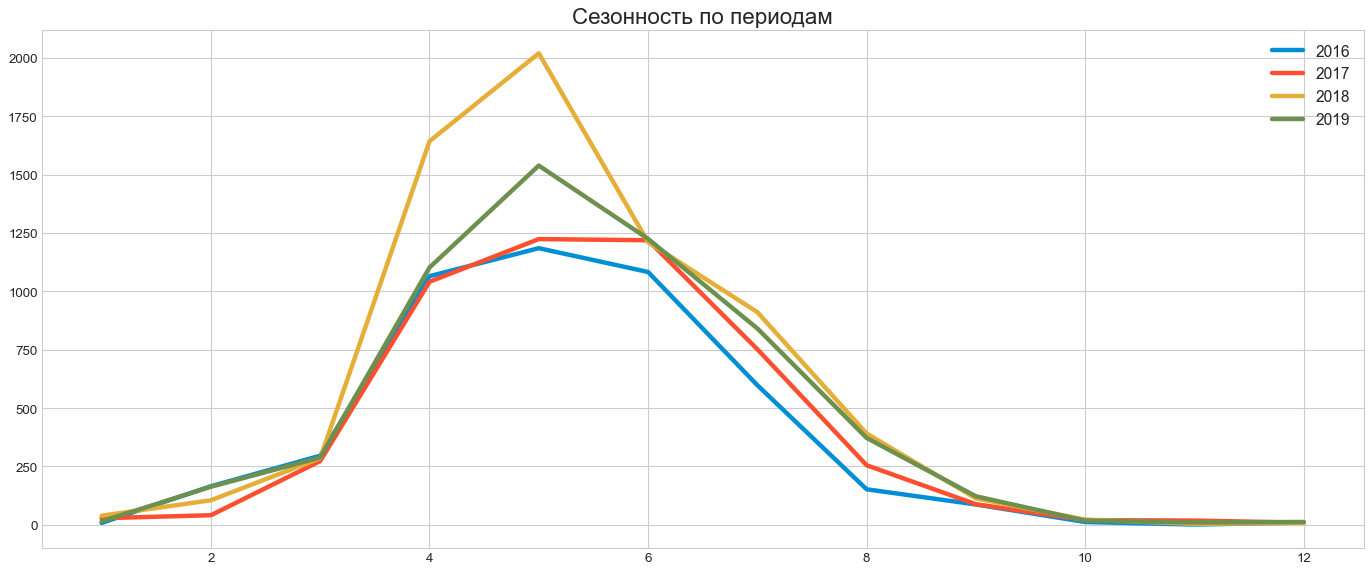

In [14]:
sesonal(dataset,12)

Декомпозиція

Text(0.5, 0.98, 'Мультипликативная модель')

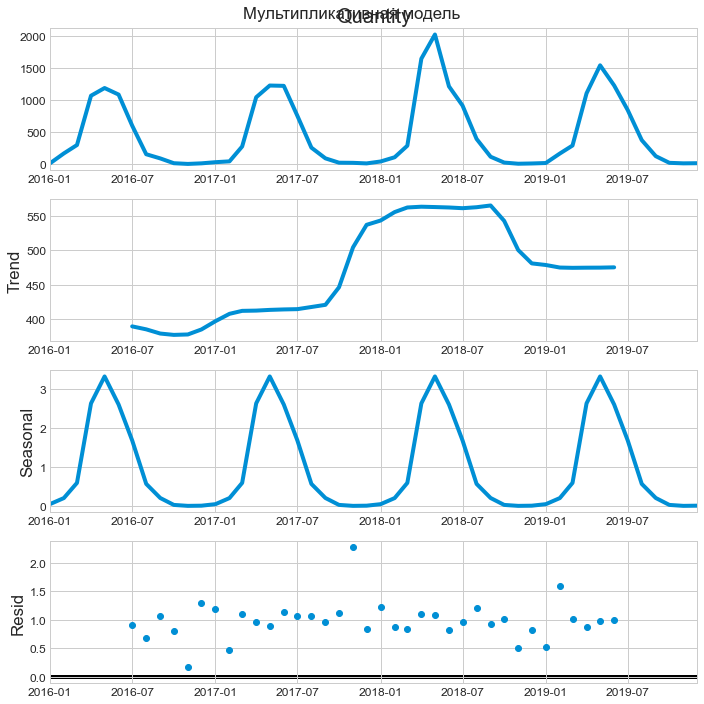

In [15]:
result_M = seasonal_decompose(dataset.Quantity, model='multiplicative', freq=12)

plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультипликативная модель')

In [16]:
result_M.seasonal['2017']

Date
2017-01-01    0.058957
2017-02-01    0.214805
2017-03-01    0.603105
2017-04-01    2.635077
2017-05-01    3.323727
2017-06-01    2.605830
2017-07-01    1.688672
2017-08-01    0.577293
2017-09-01    0.216862
2017-10-01    0.039785
2017-11-01    0.015728
2017-12-01    0.020159
Freq: MS, Name: seasonal, dtype: float64

In [17]:
result_M.trend['2017']

Date
2017-01-01    396.916667
2017-02-01    407.625000
2017-03-01    411.958333
2017-04-01    412.333333
2017-05-01    413.375000
2017-06-01    414.041667
2017-07-01    414.458333
2017-08-01    417.583333
2017-09-01    420.750000
2017-10-01    446.333333
2017-11-01    504.583333
2017-12-01    537.416667
Freq: MS, Name: trend, dtype: float64

Корегування ряду

In [18]:
dataset.loc['2018-04-01']=dataset.loc['2017-04-01']
dataset.loc['2018-05-01']=dataset.loc['2017-05-01']
dataset.loc['2019-05-01']=dataset.loc['2017-05-01']

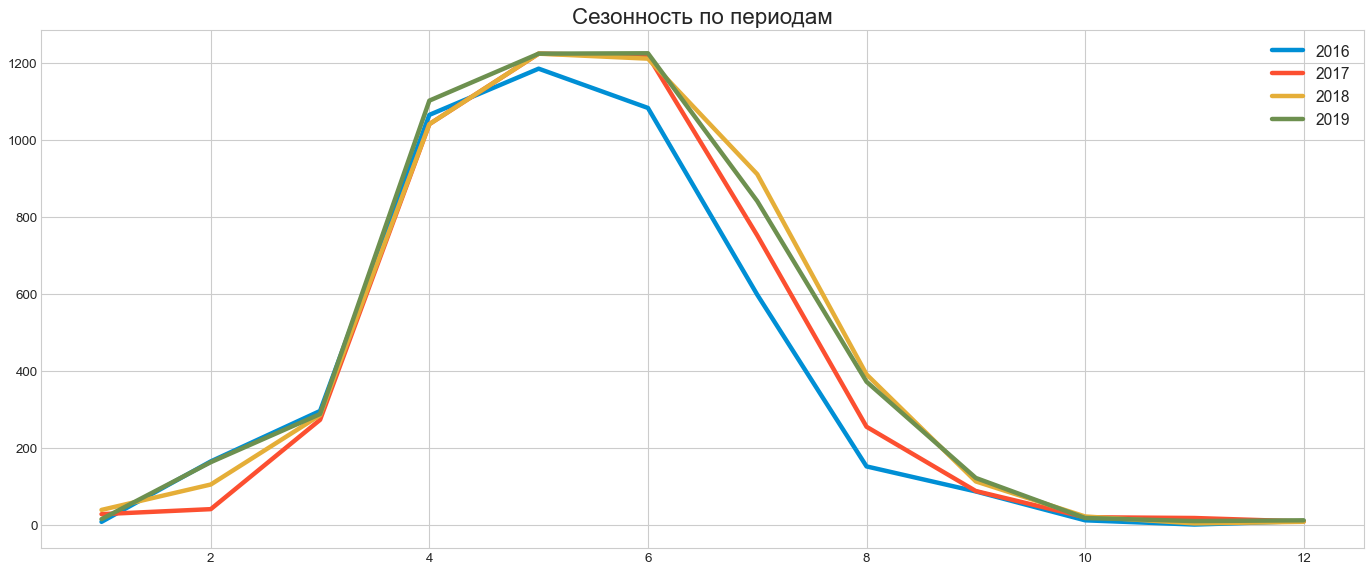

In [19]:
sesonal(dataset,12)

[<AxesSubplot:>]

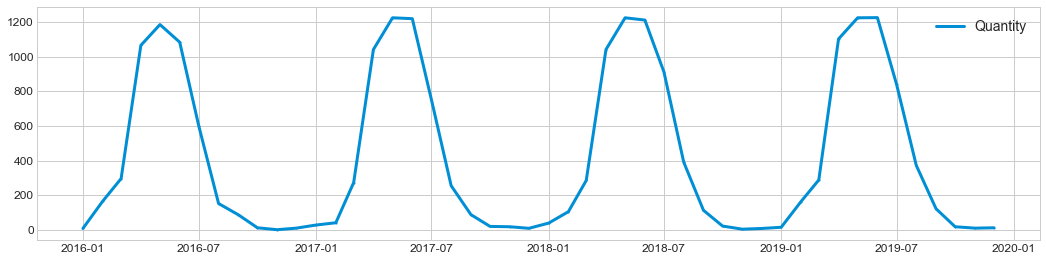

In [20]:
plot(dataset, ts_linewidth=3)

Тренувальні та тестові набори

In [21]:
train=dataset['2016':'2018']
train.head()

,Quantity
Date,
2016-01-01,8
2016-02-01,165
2016-03-01,296
2016-04-01,1065
2016-05-01,1185


In [22]:
test=dataset['2019']
test.head()

,Quantity
Date,
2019-01-01,15
2019-02-01,163
2019-03-01,288
2019-04-01,1102
2019-05-01,1224


Модель Хольта-Вінтерса

In [23]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()

In [24]:
fit2 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='mul').fit()

In [25]:
fit3 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [26]:
fit4 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='add').fit()

Тест Дікі-Фуллера

In [27]:
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стационарность:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значение = {:.3f}".format(dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные {} стационарны с вероятностью {}% процентов".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    #real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4))

In [28]:
metrics(train, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -3.822
	P-значение = 0.003
Критические значения :
	1%: -3.639224104416853 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.9512301791166293 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.614446989619377 - Данные  стационарны с вероятностью 90% процентов
MAD: 34.7069
MSE: 2834.704
MAPE: 1.0956
MPE: -0.9355
Стандартная ошибка: 53.2419


In [29]:
metrics(train, fit2.fittedvalues)

Тест на стационарность:
	T-статистика = -4.004
	P-значение = 0.001
Критические значения :
	1%: -3.639224104416853 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.9512301791166293 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.614446989619377 - Данные  стационарны с вероятностью 90% процентов
MAD: 45.0207
MSE: 4407.2136
MAPE: 3.8653
MPE: -3.6558
Стандартная ошибка: 66.3868


In [30]:
metrics(train, fit3.fittedvalues)

Тест на стационарность:
	T-статистика = -2.790
	P-значение = 0.060
Критические значения :
	1%: -3.653519805908203 - Данные не стационарны с вероятностью 99% процентов
	5%: -2.9572185644531253 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.6175881640625 - Данные  стационарны с вероятностью 90% процентов
MAD: 76.9613
MSE: 8648.6669
MAPE: 4.2278
MPE: -4.0584
Стандартная ошибка: 92.9982


In [31]:
metrics(train, fit4.fittedvalues)

Тест на стационарность:
	T-статистика = -3.728
	P-значение = 0.004
Критические значения :
	1%: -3.639224104416853 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.9512301791166293 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.614446989619377 - Данные  стационарны с вероятностью 90% процентов
MAD: 36.8081
MSE: 3031.3737
MAPE: 1.2332
MPE: -1.1417
Стандартная ошибка: 55.0579


In [32]:
metrics(test, fit1.forecast(len(test)))

Тест на стационарность:
	T-статистика = -3.294
	P-значение = 0.015
Критические значения :
	1%: -4.223238279489106 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.189368925619835 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.729839421487603 - Данные  стационарны с вероятностью 90% процентов
MAD: 37.5005
MSE: 1877.8619
MAPE: 1.0386
MPE: -1.0027
Стандартная ошибка: 43.3343


In [33]:
metrics(test, fit2.forecast(len(test)))

Тест на стационарность:
	T-статистика = -2.185
	P-значение = 0.212
Критические значения :
	1%: -4.9386902332361515 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.477582857142857 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.8438679591836733 - Данные не стационарны с вероятностью 90% процентов
MAD: 33.2336
MSE: 2370.9903
MAPE: 0.2935
MPE: -0.116
Стандартная ошибка: 48.6928


In [34]:
metrics(test, fit3.forecast(len(test)))

Тест на стационарность:
	T-статистика = -0.014
	P-значение = 0.957
Критические значения :
	1%: -4.9386902332361515 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.477582857142857 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.8438679591836733 - Данные не стационарны с вероятностью 90% процентов
MAD: 278.8957
MSE: 160769.9034
MAPE: 1.0288
MPE: -0.2109
Стандартная ошибка: 400.9612


In [35]:
metrics(test, fit4.forecast(len(test)))

Тест на стационарность:
	T-статистика = -2.590
	P-значение = 0.095
Критические значения :
	1%: -4.223238279489106 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.189368925619835 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.729839421487603 - Данные не стационарны с вероятностью 90% процентов
MAD: 57.0545
MSE: 4160.9277
MAPE: 1.8986
MPE: -1.8802
Стандартная ошибка: 64.5053


In [36]:
fit1.forecast(12)

2019-01-01      66.976294
2019-02-01     132.805095
2019-03-01     312.884881
2019-04-01    1069.022921
2019-05-01    1252.160021
2019-06-01    1239.332275
2019-07-01     938.701005
2019-08-01     418.181119
2019-09-01     140.195894
2019-10-01      49.321204
2019-11-01      31.522799
2019-12-01      64.558611
Freq: MS, dtype: float64

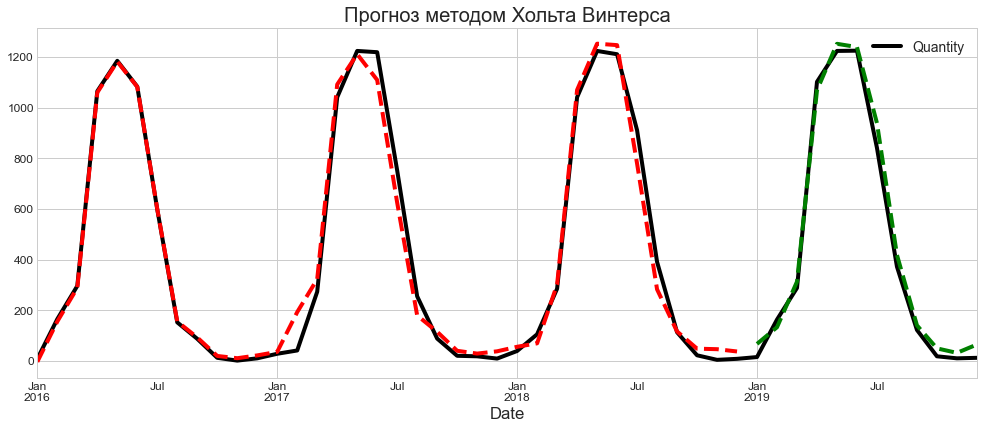

In [37]:
ax = dataset.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

Модель SARIMA

In [38]:
y = dataset['Quantity'].resample('MS').sum()

In [39]:
y['2016':]

Date
2016-01-01       8
2016-02-01     165
2016-03-01     296
2016-04-01    1065
2016-05-01    1185
2016-06-01    1083
2016-07-01     598
2016-08-01     152
2016-09-01      87
2016-10-01      12
2016-11-01       1
2016-12-01      10
2017-01-01      28
2017-02-01      41
2017-03-01     273
2017-04-01    1041
2017-05-01    1224
2017-06-01    1219
2017-07-01     752
2017-08-01     255
2017-09-01      88
2017-10-01      20
2017-11-01      18
2017-12-01       9
2018-01-01      39
2018-02-01     105
2018-03-01     285
2018-04-01    1041
2018-05-01    1224
2018-06-01    1211
2018-07-01     911
2018-08-01     391
2018-09-01     113
2018-10-01      22
2018-11-01       4
2018-12-01       8
2019-01-01      15
2019-02-01     163
2019-03-01     288
2019-04-01    1102
2019-05-01    1224
2019-06-01    1225
2019-07-01     841
2019-08-01     372
2019-09-01     122
2019-10-01      18
2019-11-01      10
2019-12-01      12
Freq: MS, Name: Quantity, dtype: int64

In [40]:
model = auto_arima(y, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=397.908, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=394.459, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=394.978, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=400.127, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=392.484, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=394.424, Time=0.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=393.573, Time=0.09 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=394.125, Time=0.12 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=393.014, Time=0.07 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=392.613, Time=0.20 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=392.092, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12]             : AIC=394.091, Time=0.11 sec
 ARIMA(1,0,0)(0,1,1)[12]             : AI

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [41]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4867      0.145      3.349      0.001       0.202       0.772
sigma2      2793.4168    471.715      5.922      0.000    1868.872    3717.962


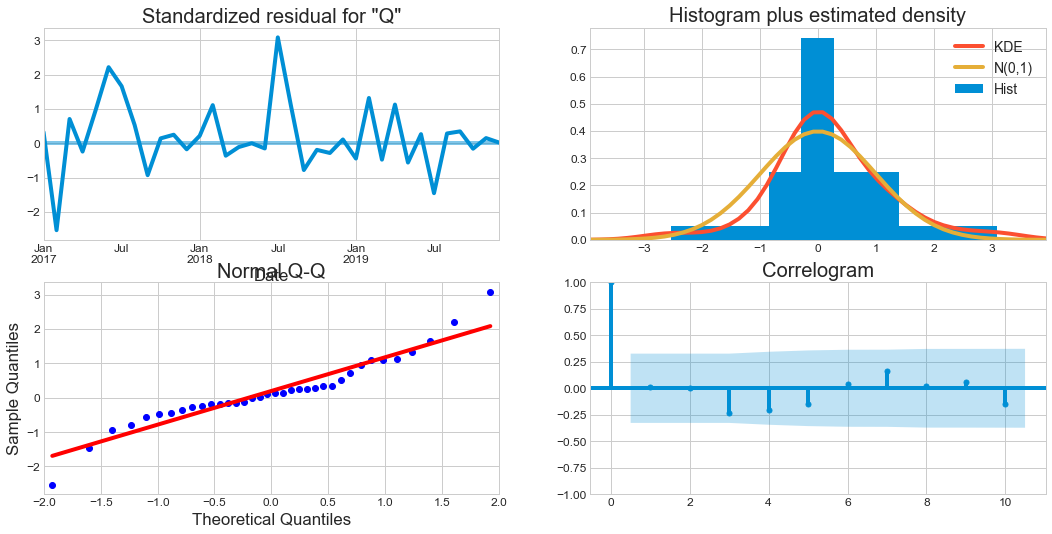

In [42]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

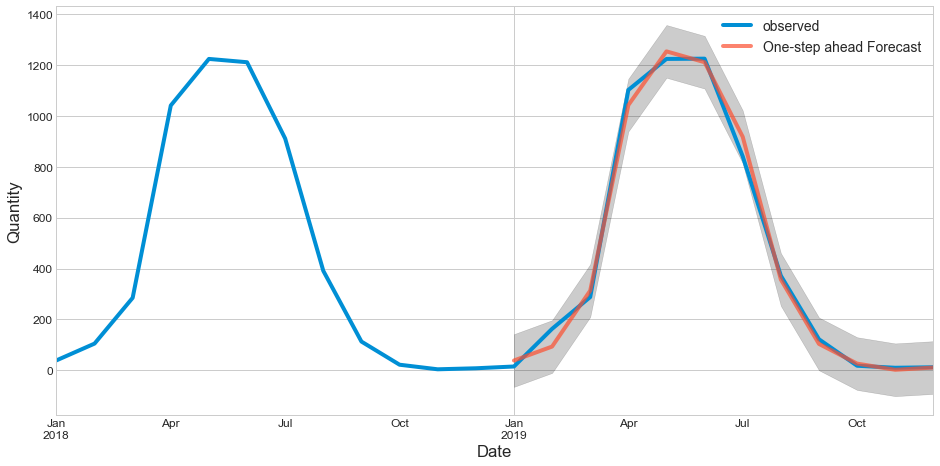

In [49]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
plt.legend()
plt.show()

In [44]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2795.89


In [45]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 52.88


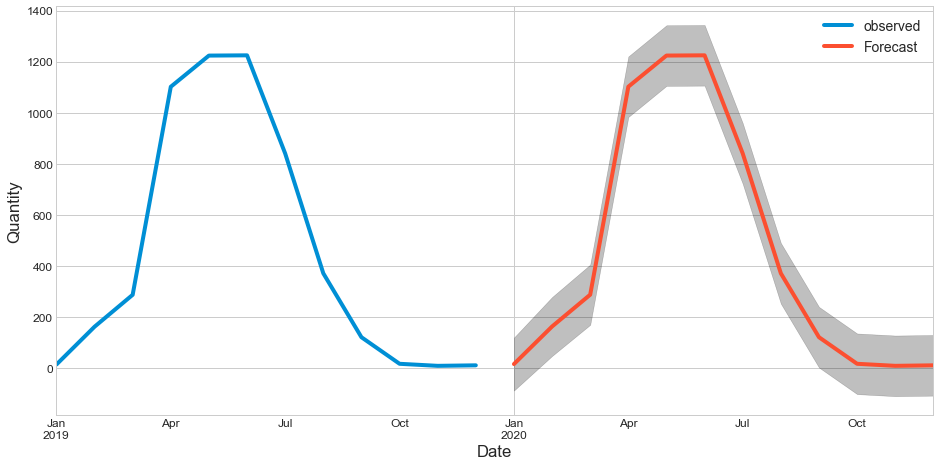

In [46]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y['2019':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
plt.legend()
plt.show()